In [22]:
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
from numba import jit,cuda
import shutil
import re
import tensorflow as tf
from time import time
import pickle as pkl
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.models import Sequential
from skimage.io import imsave


In [34]:
%%cmd
pip install wandb
pip install scikit-image
pip install skimage
pip install numba
pip install keras-unet

Microsoft Windows [Version 10.0.22621.608]
(c) Microsoft Corporation. All rights reserved.

(machineLearning) d:\Python Project\Photo Coloring>pip install wandb

(machineLearning) d:\Python Project\Photo Coloring>pip install scikit-image
     -------------------------------------- 12.1/12.1 MB 699.9 kB/s eta 0:00:00
     ------------------------------------ 208.5/208.5 kB 422.8 kB/s eta 0:00:00
  Using cached scipy-1.9.1-cp39-cp39-win_amd64.whl (38.6 MB)
     ---------------------------------------- 4.2/4.2 MB ? eta 0:00:00
     ---------------------------------------- 3.4/3.4 MB 658.3 kB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 221.0 kB/s eta 0:00:00

(machineLearning) d:\Python Project\Photo Coloring>pip install skimage
  Using cached skimage-0.0.tar.gz (757 bytes)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      
      *** Please install the `scikit-image` package (instead of `skimage`) ***
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.



(machineLearning) d:\Python Project\Photo Coloring>pip install numba

(machineLearning) d:\Python Project\Photo Coloring>pip install keras-unet

(machineLearning) d:\Python Project\Photo Coloring>

In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
sess

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5



In [3]:
trainImageColorful = list(map(lambda x : "data/train/"+x ,os.listdir("data/train/")))
testImageColorful = list(map(lambda x : "data/test/"+x ,os.listdir("data/test/")))
valImageColorful = list(map(lambda x : "data/val/"+x ,os.listdir("data/val/")))


In [5]:
len(trainImageColorful)

6000

In [4]:
# Building the neural network
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [19]:
def preprocess_image_to_gray_lab(img):
    img = cv2.resize(cv2.imread(img),(400,400))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #img = img_to_array(load_img(img))
    img = rgb2lab(img/255)
    img = img[:,:,0]
    img = img.reshape(400, 400, 1)
    
    return img

def preprocess_image_to_lab(img):
    img = cv2.resize(cv2.imread(img),(400,400))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #img = img_to_array(load_img(img))
    img = rgb2lab(img/255)
    img = img[:,:,1:]
    img /= 128
    img = img.reshape(400, 400, 2)

    return img



In [8]:
trainImageColorful[0]

'data/train/1001773457_577c3a7d70.jpg'

In [9]:
start = time()

valX={}
valY={}


for ix,img in enumerate(valImageColorful):
    

   
    valX[img.split("/")[2][:-4]] = preprocess_image_to_gray_lab(img)
    valY[img.split("/")[2][:-4]] = preprocess_image_to_lab(img)
 

    if ix%100==0:
        print("Encoding val image - "+str(ix))

print("Time taken in seconds = ", time()-start)

start = time()

testX={}
testY={}


for ix,img in enumerate(testImageColorful):
    

   
    testX[img.split("/")[2][:-4]] = preprocess_image_to_gray_lab(img)
    testY[img.split("/")[2][:-4]] = preprocess_image_to_lab(img)
 

    if ix%100==0:
        print("Encoding test image - "+str(ix))

print("Time taken in seconds = ", time()-start)

Encoding val image - 0
Encoding val image - 100
Encoding val image - 200
Encoding val image - 300
Encoding val image - 400
Encoding val image - 500
Encoding val image - 600
Encoding val image - 700
Encoding val image - 800
Encoding val image - 900
Encoding val image - 1000
Time taken in seconds =  31.33377766609192
Encoding test image - 0
Encoding test image - 100
Encoding test image - 200
Encoding test image - 300
Encoding test image - 400
Encoding test image - 500
Encoding test image - 600
Encoding test image - 700
Encoding test image - 800
Encoding test image - 900
Time taken in seconds =  16.907161235809326


In [10]:
import pickle as pkl


with open("pickles/process_val_imagesX.pkl","wb") as process_pickle:
    pkl.dump(valX,process_pickle)
with open("pickles/process_val_imagesY.pkl","wb") as process_pickle:
    pkl.dump(valY,process_pickle)



with open("pickles/process_test_imagesX.pkl","wb") as process_pickle:
    pkl.dump(testX,process_pickle)
with open("pickles/process_test_imagesY.pkl","wb") as process_pickle:
    pkl.dump(testY,process_pickle)

 

In [6]:

with open("pickles/process_test_imagesX.pkl","rb") as f:
    testX = pkl.load(f)
with open("pickles/process_test_imagesY.pkl","rb") as f:
    testY = pkl.load(f)
with open("pickles/process_val_imagesX.pkl","rb") as f:
    valX = pkl.load(f)
with open("pickles/process_val_imagesY.pkl","rb") as f:
    valY = pkl.load(f)

KeyboardInterrupt: 

In [12]:
start = time()

trainX={}
trainY={}


for ix, img in enumerate(trainImageColorful):
    
    img=trainImageColorful[ix]
   
    
    trainX[img.split("/")[2][:-4]] = preprocess_image_to_gray_lab(img)
    trainY[img.split("/")[2][:-4]] = preprocess_image_to_lab(img)
   
 

    if ix%100==0:
        print("Encoding image - "+str(ix))

print("Time taken in seconds = ", time()-start)

Encoding image - 0
Encoding image - 100
Encoding image - 200
Encoding image - 300
Encoding image - 400
Encoding image - 500
Encoding image - 600
Encoding image - 700
Encoding image - 800
Encoding image - 900
Encoding image - 1000
Encoding image - 1100
Encoding image - 1200
Encoding image - 1300
Encoding image - 1400
Encoding image - 1500
Encoding image - 1600
Encoding image - 1700
Encoding image - 1800
Encoding image - 1900
Encoding image - 2000
Encoding image - 2100
Encoding image - 2200
Encoding image - 2300
Encoding image - 2400
Encoding image - 2500
Encoding image - 2600
Encoding image - 2700
Encoding image - 2800
Encoding image - 2900
Encoding image - 3000
Encoding image - 3100
Encoding image - 3200
Encoding image - 3300
Encoding image - 3400
Encoding image - 3500
Encoding image - 3600
Encoding image - 3700
Encoding image - 3800
Encoding image - 3900
Encoding image - 4000
Encoding image - 4100
Encoding image - 4200
Encoding image - 4300
Encoding image - 4400
Encoding image - 4500


In [ ]:
with open("pickles/process_train_imagesX.pkl","wb") as process_pickle:
    pkl.dump(trainX,process_pickle)
with open("pickles/process_train_imagesY.pkl","wb") as process_pickle:
    pkl.dump(trainY,process_pickle)

In [7]:
import pickle as pkl

with open("pickles/process_train_imagesX.pkl","rb") as f:
    trainX = pkl.load(f)

with open("pickles/process_train_imagesY.pkl","rb") as f:
    trainY = pkl.load(f)

In [15]:
trainImageColorful

['data/train/1001773457_577c3a7d70.jpg',
 'data/train/1002674143_1b742ab4b8.jpg',
 'data/train/1007129816_e794419615.jpg',
 'data/train/1007320043_627395c3d8.jpg',
 'data/train/1009434119_febe49276a.jpg',
 'data/train/1012212859_01547e3f17.jpg',
 'data/train/1015584366_dfcec3c85a.jpg',
 'data/train/101654506_8eb26cfb60.jpg',
 'data/train/101669240_b2d3e7f17b.jpg',
 'data/train/1016887272_03199f49c4.jpg',
 'data/train/1019077836_6fc9b15408.jpg',
 'data/train/1019604187_d087bf9a5f.jpg',
 'data/train/1020651753_06077ec457.jpg',
 'data/train/1022454332_6af2c1449a.jpg',
 'data/train/1022975728_75515238d8.jpg',
 'data/train/1024138940_f1fefbdce1.jpg',
 'data/train/1026685415_0431cbf574.jpg',
 'data/train/1028205764_7e8df9a2ea.jpg',
 'data/train/1030985833_b0902ea560.jpg',
 'data/train/103106960_e8a41d64f8.jpg',
 'data/train/103205630_682ca7285b.jpg',
 'data/train/1032460886_4a598ed535.jpg',
 'data/train/1034276567_49bb87c51c.jpg',
 'data/train/104136873_5b5d41be75.jpg',
 'data/train/10425903

In [32]:

def data_generator(trainX,num_photos_per_batch):
    
    X, y = [], []

    n = 0

    while True:

        for key in trainImageColorful:
            n +=1

            photo = trainX[key.split("/")[2][:-4]]

            photoColor = trainY[key.split("/")[2][:-4]]

          
          
                
            X.append(photo)
                   
            y.append(photoColor)
         

            if n==num_photos_per_batch:
                u = np.array(X)
                w = np.array(y)
            
             
               
                yield(u,w)
                
                X,  y = [], []
                n = 0

def val_generator(valX,num_photos_per_batch):
    
    X, y = [], []

    n = 0

    while True:

        for key in valImageColorful:
            n +=1

            photo = valX[key.split("/")[2][:-4]]

            photoColor = valY[key.split("/")[2][:-4]]

          
          
                
            X.append(photo)
                   
            y.append(photoColor)
         

            if n==num_photos_per_batch:
                u = np.array(X)
                w = np.array(y)
            
             
               
                yield(u,w)
                
                X,  y = [], []
                n = 0

In [9]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [18]:
import wandb 
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: Network error (ReadTimeout), entering retry loop.


In [26]:

model.compile(optimizer='rmsprop',loss='mse')

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 224, 224, 64  0          ['conv2d[0][0]']                 
 out2D)                         )                                                             

In [33]:
epochs = 30
number_pics_per_bath = 6
steps = len(trainImageColorful)//number_pics_per_bath

In [34]:
@jit(target_backend='cuda') 
def runModel():
    for i in range(epochs):
     
        generator = data_generator(trainX=trainX,num_photos_per_batch=number_pics_per_bath)
 
        model.fit(generator,epochs=10,steps_per_epoch=steps,verbose=1)
        model.save("./model_weights/model_"+str(i)+".h5")

In [35]:
runModel()

C:\Users\hosma\AppData\Local\Temp\ipykernel_18740\3510875963.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "runModel" failed type inference due to: Untyped global name 'data_generator': Cannot determine Numba type of <class 'function'>

File "C:\Users\hosma\AppData\Local\Temp\ipykernel_18740\3510875963.py", line 5:
def runModel():
    <source elided>
        print(f"Epoch + {i}")
        generator = data_generator(trainX=trainX,num_photos_per_batch=number_pics_per_bath)
        ^

  @jit(target_backend='cuda')
C:\Users\hosma\AppData\Local\Temp\ipykernel_18740\3510875963.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runModel" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "C:\Users\hosma\AppData\Local\Temp\ipykernel_18740\3510875963.py", line 3:
def runModel():
    for i in range(epochs):
    ^

  @jit(

Epoch + 0
Epoch 1/10


c:\Users\hosma\anaconda3\envs\machineLearning\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "runModel" was compiled in object mode without forceobj=True.

File "C:\Users\hosma\AppData\Local\Temp\ipykernel_18740\3510875963.py", line 3:
def runModel():
    for i in range(epochs):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
c:\Users\hosma\anaconda3\envs\machineLearning\lib\site-packages\numba\core\object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "C:\Users\hosma\AppData\Local\Temp\ipykernel_18740\3510875963.py", line 3:
def runModel():
    for i in range(epochs):
    ^

  warnings.warn(errors.NumbaDeprecationWarning(msg,


1000/1000 [==============================] - 506s 499ms/step - loss: 0.5298 - acc: 0.3948
Epoch 2/10
1000/1000 [==============================] - 501s 501ms/step - loss: 0.5297 - acc: 0.3946
Epoch 3/10
1000/1000 [==============================] - 500s 500ms/step - loss: 0.5296 - acc: 0.3946
Epoch 4/10
1000/1000 [==============================] - 501s 501ms/step - loss: 0.5295 - acc: 0.3959
Epoch 5/10
1000/1000 [==============================] - 501s 501ms/step - loss: 0.5295 - acc: 0.3972
Epoch 6/10
1000/1000 [==============================] - 500s 500ms/step - loss: 0.5294 - acc: 0.3960
Epoch 7/10
1000/1000 [==============================] - 500s 500ms/step - loss: 0.5294 - acc: 0.3961
Epoch 8/10
1000/1000 [==============================] - 500s 500ms/step - loss: 0.5294 - acc: 0.3983
Epoch 9/10
1000/1000 [==============================] - 500s 500ms/step - loss: 0.5293 - acc: 0.3972
Epoch 10/10
1000/1000 [==============================] - 502s 502ms/step - loss: 0.5292 - acc: 0.3963


KeyboardInterrupt: 

In [ ]:
print(model.evaluate(X, Y, batch_size=1))
output = model.predict(X)
output *= 128
# Output colorizations
cur = np.zeros((400, 400, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0]
imsave("img_result.png", lab2rgb(cur))
imsave("img_gray_version.png", rgb2gray(lab2rgb(cur)))

In [13]:
from keras.models import Model,load_model
model = load_model("model_weights\model_0.h5")

In [26]:
import cv2,numpy as np
from matplotlib import pyplot as plt

def predict_caption(photo):
    
    temp = model.predict(np.reshape(preprocess_image_to_gray_lab(photo),(1,400,400,1)))

    plt.imshow(temp[0])
    plt.axis("off")
    plt.show()



1003163366_44323f5815.jpg
(410, 500, 3)
(410, 500)
(224, 224)
(224, 224, 3)
1/1 [==============================] - 0s 35ms/step


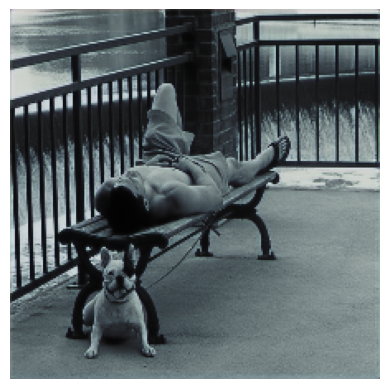

102351840_323e3de834.jpg
(198, 500, 3)
(198, 500)
(224, 224)
(224, 224, 3)
1/1 [==============================] - 0s 29ms/step


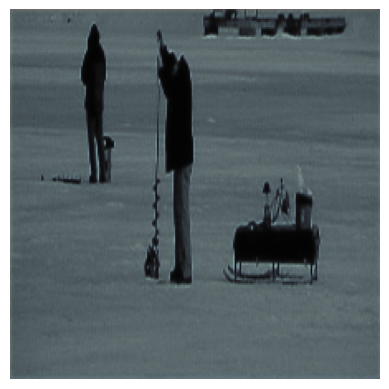

102455176_5f8ead62d5.jpg
(500, 333, 3)
(500, 333)
(224, 224)
(224, 224, 3)
1/1 [==============================] - 0s 28ms/step


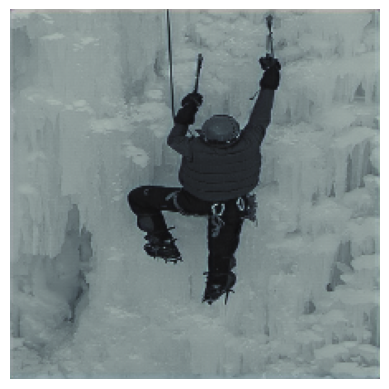

1042020065_fb3d3ba5ba.jpg
(334, 500, 3)
(334, 500)
(224, 224)
(224, 224, 3)
1/1 [==============================] - 0s 35ms/step


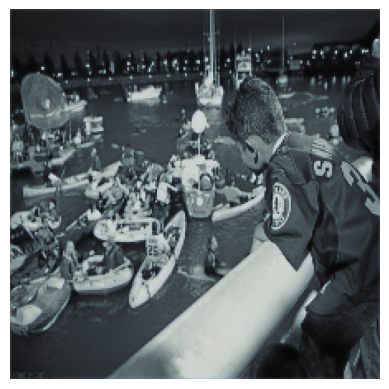

1056359656_662cee0814.jpg
(500, 375, 3)
(500, 375)
(224, 224)
(224, 224, 3)
1/1 [==============================] - 0s 37ms/step


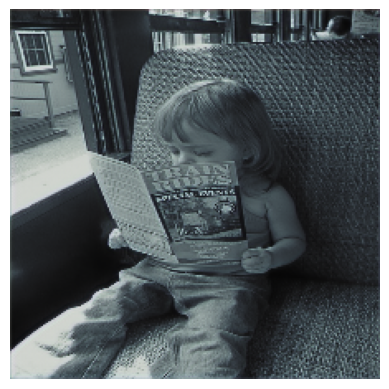

1072153132_53d2bb1b60.jpg
(500, 333, 3)
(500, 333)
(224, 224)
(224, 224, 3)
1/1 [==============================] - 0s 40ms/step


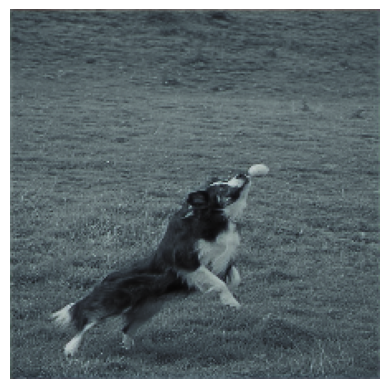

1084040636_97d9633581.jpg
(375, 500, 3)
(375, 500)
(224, 224)
(224, 224, 3)
1/1 [==============================] - 0s 28ms/step


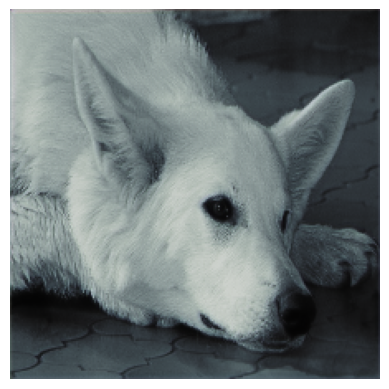

1087168168_70280d024a.jpg
(333, 500, 3)
(333, 500)
(224, 224)
(224, 224, 3)
1/1 [==============================] - 0s 34ms/step


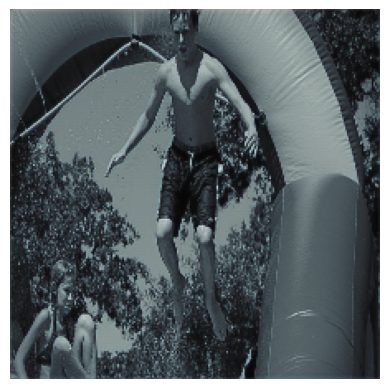

1088767354_2acee738cf.jpg
(500, 500, 3)
(500, 500)
(224, 224)
(224, 224, 3)
1/1 [==============================] - 0s 32ms/step


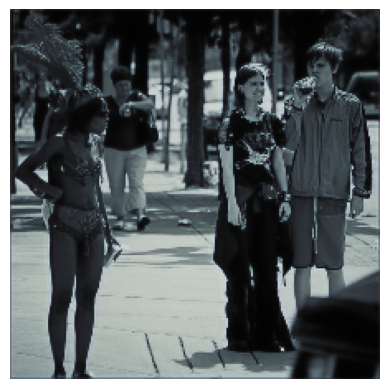

1089181217_ee1167f7af.jpg
(500, 500, 3)
(500, 500)
(224, 224)
(224, 224, 3)
1/1 [==============================] - 0s 32ms/step


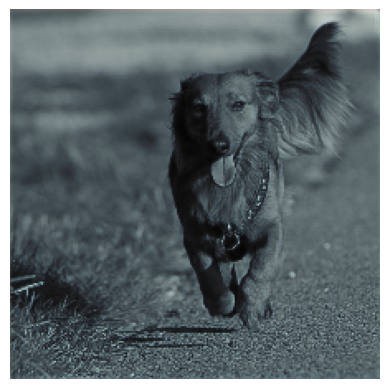

1093716555_801aacef79.jpg
(375, 500, 3)
(375, 500)
(224, 224)
(224, 224, 3)
1/1 [==============================] - 0s 42ms/step


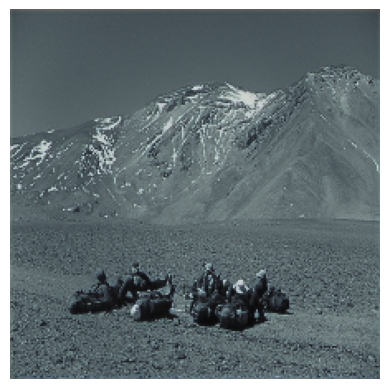

1095590286_c654f7e5a9.jpg
(500, 400, 3)
(500, 400)
(224, 224)
(224, 224, 3)
1/1 [==============================] - 0s 36ms/step


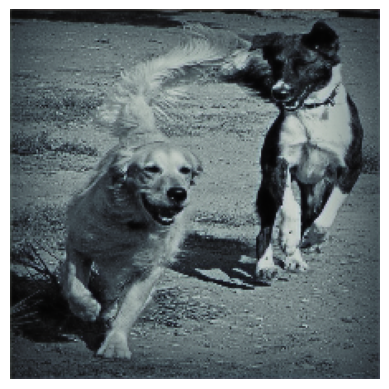

1096165011_cc5eb16aa6.jpg
(375, 500, 3)
(375, 500)
(224, 224)
(224, 224, 3)
1/1 [==============================] - 0s 35ms/step


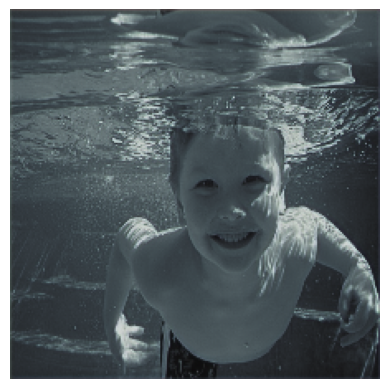

109738763_90541ef30d.jpg
(375, 500, 3)
(375, 500)
(224, 224)
(224, 224, 3)
1/1 [==============================] - 0s 41ms/step


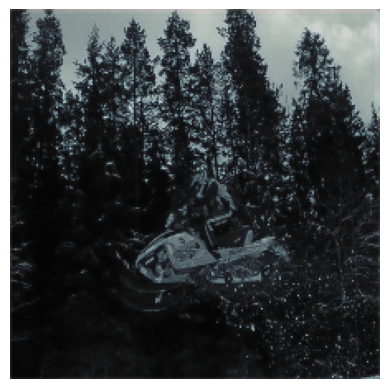

109823394_83fcb735e1.jpg
(332, 500, 3)
(332, 500)
(224, 224)
(224, 224, 3)
1/1 [==============================] - 0s 33ms/step


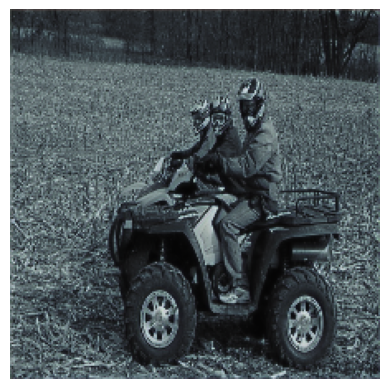

111537222_07e56d5a30.jpg
(332, 500, 3)
(332, 500)
(224, 224)
(224, 224, 3)
1/1 [==============================] - 0s 29ms/step


KeyboardInterrupt: 

In [30]:
for i in os.listdir("data/test/"):
    print(i)
    predict_caption("data/test/"+i)